In [1]:
# IMPORT STATEMENTS
import pandas as pd, numpy as np
from twarc import Twarc2, expansions
import datetime, json, matplotlib.pyplot as plt
import itertools, collections

%matplotlib inline

# Data collection

In [8]:
# FIRST THINGS FIRST: AUTHENETICATION 
# This is where you initialize the client with your own bearer token 
client = Twarc2(bearer_token="INSERT YOUR TOKEN HERE")


In [10]:
def main():

    # This is where you enter whatever you want to search for 
    # see this link for examples of other types of search queries:
    # https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md
    query = f"exxonmobil"

    # Specify the start time in UTC for the time period you want Tweets from
    start_time = datetime.datetime(2022, 6, 1, 0, 0, 0, 0, datetime.timezone.utc)

    # Specify the end time in UTC for the time period you want Tweets from
    end_time = datetime.datetime(2022, 6, 30, 0, 0, 0, 0, datetime.timezone.utc)
    
    # The search_all method call the full-archive search endpoint to get Tweets based on the query, start and end times
    search_results = client.search_all(query=query, start_time=start_time, end_time=end_time, max_results=100)

    # Twarc returns all Tweets for the criteria set above, so we page through the results
    for page in search_results:
        # The Twitter API v2 returns the Tweet information and the user, media etc.  separately
        # so we use expansions.flatten to get all the information in a single JSON
        result = expansions.flatten(page)
        #print(result)
        
        # We will open the file and append one JSON object per new line
        with open('results.json', 'a+') as filehandle:
            for tweet in result:
                filehandle.write('%s\n' % json.dumps(tweet))
                
if __name__ == "__main__":
    main()

rate limit exceeded: sleeping 147.73747515678406 secs
rate limit exceeded: sleeping 199.72120189666748 secs
caught requests exception: HTTPSConnectionPool(host='api.twitter.com', port=443): Read timed out. (read timeout=31)
rate limit exceeded: sleeping 126.66696286201477 secs


In [11]:
# extract example tweet 
sample = None
with open('results.json') as f:
    for jsonObj in f:
        tDict = json.loads(jsonObj)
        sample = tDict
        # tweet_list.append(tDict)
        break


In [12]:
# View example tweet 
sample

{'created_at': '2022-07-22T23:56:47.000Z',
 'author_id': '3230532104',
 'source': 'Twitter Web App',
 'possibly_sensitive': False,
 'public_metrics': {'retweet_count': 100,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'id': '1550630972265484289',
 'entities': {'mentions': [{'start': 3,
    'end': 19,
    'username': 'ProfTerryHughes',
    'id': '611278121',
    'entities': {'url': {'urls': [{'start': 0,
        'end': 23,
        'url': 'https://t.co/Rv342q3Njd',
        'expanded_url': 'https://scholar.google.com.au/citations?hl=en&user=MhJ2LfsAAAAJ&view_op=list_work',
        'display_url': 'scholar.google.com.au/citations?hl=e…'}]},
     'description': {'hashtags': [{'start': 31, 'end': 39, 'tag': 'science'},
       {'start': 41, 'end': 53, 'tag': 'environment'},
       {'start': 55, 'end': 61, 'tag': 'coral'},
       {'start': 62, 'end': 68, 'tag': 'reefs'},
       {'start': 70, 'end': 78, 'tag': 'climate'},
       {'start': 87, 'end': 100, 'tag': 'conservation'}]}}

# Now that we have the data, we need to organise it

In [249]:
import json, glob

columns = ['tid','date','username','followers','verified','text','rt_count','conversation_id'] # add all fields extracted 
#new = pd.DataFrame(columns=columns)
master = dict()
total = 0 
for file in glob.glob('*.json'):
    with open(file) as f:
        for n,jsonObj in enumerate(f):
            tDict = json.loads(jsonObj)
            input_tweet = dict()
            
            if 'id' not in tDict.keys(): 
                print("Missing id:", file, n)
                continue
            else:
                input_tweet['tid'] = tDict['id']
            
            if 'created_at' not in tDict.keys():
                print('Missing date:', file, n)
            else:
                input_tweet['date'] = tDict['created_at']
            
            if 'author' not in tDict.keys():
                print("Missing author:",file, n)
            else:
                input_tweet['username'] = tDict['author']['username']
                input_tweet['followers'] = tDict['author']['public_metrics']['followers_count']
                #input_tweet['location'] = tDict['author']['location']
                input_tweet['verified'] = tDict['author']['verified']
                
            if 'text' not in tDict.keys():
                print('Missing text:', file,n)
            else:
                input_tweet['text'] = tDict['text']
            
            # check how this is referred to in tweets, check what retweet count is called 
            if 'public_metrics' not in tDict.keys():
                print('Missing metrics:', file,n)
            else:
                input_tweet['rt_count'] = tDict['public_metrics']['retweet_count']

            if 'conversation_id' not in tDict.keys():
                print('Missing conversation id:', file,n)
            else:
                input_tweet['conversation_id']=tDict['conversation_id']
            total+=1
            master[total]=input_tweet

            #new = new.append(input_tweet,ignore_index=True)
            
        

In [17]:
# Convert to dataframe 
masterdf = pd.DataFrame.from_dict(master,orient='index')

In [239]:
# Check to make sure no duplicates
masterdf = masterdf.drop_duplicates('tid')

In [257]:
masterdf['username'].value_counts().shape

(72842,)

# Next, it's time to clean the data

## Check out word frequency to spot any issues

In [299]:
from collections import defaultdict

def freq(df,text_col):
    word_freq = defaultdict(int)
    for t in df[text_col]:
        if type(t)==str:
            for i in t.split():
                word_freq[i] += 1
        else:
            for i in t:
                word_freq[i] += 1
    return word_freq

overall_freq = freq(masterdf,'text')
print(sorted(overall_freq, key=overall_freq.get, reverse=True)[:30])

['RT', 'the', 'to', 'ExxonMobil', 'billion', '-', 'of', 'is', 'profits:', 'gas', 'a', 'and', 'from', '@RBReich:', 'Q1', 'that', 'so', 'more', '2022', 'in', 'increase', '2021', 'BP', 'compared', '(a', 'Q1)', 'than', '100%', '$5,480,000,000', '"Why']


In [259]:
# Define preprocessing pipeline

import nltk, string, re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stops = stopwords.words('english')
stops.extend(['exxonmobil','rt','’','amp'])

def preprocess_tweet(text):

    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # convert text to lower-case
    nopunc = nopunc.lower()
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', nopunc)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    # remove repeated characters and stem
    nopunc = word_tokenize(nopunc)
    # remove stopwords from final word list
    return [word for word in nopunc if word not in stops]


[nltk_data] Downloading package stopwords to /Users/mary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [260]:
# Run the preprocessing on the tweets 
masterdf['new_text']=[preprocess_tweet(tweet) for tweet in masterdf['text']]

# Only keep the tweets that are nonempty after cleaning
masterdf = masterdf[masterdf['new_text']!='']

## Quick look (again) at word frequency 

In [261]:
from collections import defaultdict

overall_freq = freq(masterdf,'new_text')
print(sorted(overall_freq, key=overall_freq.get, reverse=True)[:30])

['billion', 'q1', 'profits', 'bp', 'gas', '2021', 'rbreich', 'chevron', '2022', 'oil', 'first', 'increase', 'compared', '100', '5480000000', 'expensive', '6…', 'bravenewfilms', 'quarter', 'shell', 'biden', 'profit', 'reported', 'net', '55', 'president', 'year', 'tinubu', 'big', 'bola']


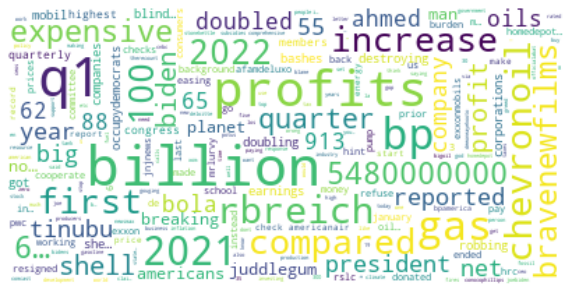

In [262]:
# Visualise word frequency

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# https://amueller.github.io/word_cloud/auto_examples/frequency.html#sphx-glr-auto-examples-frequency-py

#wordcloud = WordCloud(width = 500, height = 500,max_font_size=50, max_words=500, background_color="white").generate(masterdf['cleaned'])
wordcloud = WordCloud(max_font_size=40, max_words=500, background_color="white").generate_from_frequencies(overall_freq)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [263]:
# need to alter structure of cleaned tweets for LIWC processing (needs to be string instead of list of strings)
masterdf['cleaned'] = [' '.join(text) for text in masterdf['new_text']]

In [264]:
# Save data to csv 
masterdf.to_csv('exxon_sample.csv',header=True, index=False)

## Also can check out the hashtags!

In [265]:
tags = []
for i in masterdf['text']:
    for word in i.split():
        if word.startswith('#'): tags.append(word.strip('.').lower())
            
tag_counts = dict(pd.Series(tags).value_counts())

In [266]:
print(sorted(tag_counts, key=tag_counts.get, reverse=True)[:30])

['#exxonmobil', '#bigoil', '#oott', '#corporategreed', '#oil', '#gasprices', '#stocks', '#votethemallout2022', '#stoppricegouging', '#foxbusiness', '#gas', '#pricegouging', '#ourchildrensfutur…', '#energy', '#biden', '#extinctionrebellion', '#mwn', '#c…', '#shell', '#stockmarket', '#chevron', '#exxon', '#russia', '#edinburghpride', '#inflation', '#bp', '#lng', '#carboncredits', '#carbonoffset', '#oilandgas']


# Now let's pass it through LIWC

In [267]:
# load new liwc data and examine
liwc = pd.read_csv('LIWC2015 Results (exxon_sample.csv).csv')

/Users/mary/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,3,4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [269]:
liwc.head()

,A,B,C,D,E,F,G,H,I,J,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,tid,date,username,followers,verified,text,rt_count,conversation_id,parsed_date,new_text,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1542659131307200513,2022-06-30T23:59:32.000Z,hardinsj,182,False,RT @WstrnPriorities: America's top 5 oil compa...,549,1542659131307200513,2022-06-30 23:59:32,"['wstrnpriorities', 'americas', 'top', '5', 'o...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1542659076504850432,2022-06-30T23:59:19.000Z,jebelirhoud,101,False,good old media propaganda bought to you by sau...,0,1542659076504850432,2022-06-30 23:59:19,"['good', 'old', 'media', 'propaganda', 'bought...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1542658763911471105,2022-06-30T23:58:05.000Z,Michele07317502,21,False,RT @KportldyJean: @ltgrusselhonore @GOP @exxon...,46,1542658763911471105,2022-06-30 23:58:05,"['kportldyjean', 'ltgrusselhonore', 'gop', 'ms...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1542658656579096577,2022-06-30T23:57:39.000Z,mbjunior4real,71,False,RT @DeeOneAyekooto: Before TINUBU joined Exxon...,169,1542658656579096577,2022-06-30 23:57:39,"['deeoneayekooto', 'tinubu', 'joined', 'anders...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
# As the previous cell shows, we need to fix the column names because when they come out of liwc, 
# the original column names are not retained but instead put in the first row of the dataframe. 

columns = [
 'tid',
 'date',
 'username',
 'followers',
 'verified',
 'text',
 'rt_count',
 'parsed_date',
 'conversation_id',
 'new_text',
 'cleaned'] + list(liwc.columns[11:])

liwc.columns = columns
liwc=liwc.drop(0)

In [271]:
liwc.head()

,tid,date,username,followers,verified,text,rt_count,parsed_date,conversation_id,new_text,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
1,1542659131307200513,2022-06-30T23:59:32.000Z,hardinsj,182,False,RT @WstrnPriorities: America's top 5 oil compa...,549,1542659131307200513,2022-06-30 23:59:32,"['wstrnpriorities', 'americas', 'top', '5', 'o...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1542659076504850432,2022-06-30T23:59:19.000Z,jebelirhoud,101,False,good old media propaganda bought to you by sau...,0,1542659076504850432,2022-06-30 23:59:19,"['good', 'old', 'media', 'propaganda', 'bought...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1542658763911471105,2022-06-30T23:58:05.000Z,Michele07317502,21,False,RT @KportldyJean: @ltgrusselhonore @GOP @exxon...,46,1542658763911471105,2022-06-30 23:58:05,"['kportldyjean', 'ltgrusselhonore', 'gop', 'ms...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1542658656579096577,2022-06-30T23:57:39.000Z,mbjunior4real,71,False,RT @DeeOneAyekooto: Before TINUBU joined Exxon...,169,1542658656579096577,2022-06-30 23:57:39,"['deeoneayekooto', 'tinubu', 'joined', 'anders...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1542657436317896705,2022-06-30T23:52:48.000Z,hrabos_m,191,False,RT @KportldyJean: @ltgrusselhonore @GOP @exxon...,46,1542657436317896705,2022-06-30 23:52:48,"['kportldyjean', 'ltgrusselhonore', 'gop', 'ms...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Quickly examine a few feature distributions

In [272]:
liwc['posemo'].describe()

count    97160.000000
mean         4.890987
std          5.879098
min          0.000000
25%          0.000000
50%          5.560000
75%          7.140000
max        100.000000
Name: posemo, dtype: float64

<AxesSubplot:>

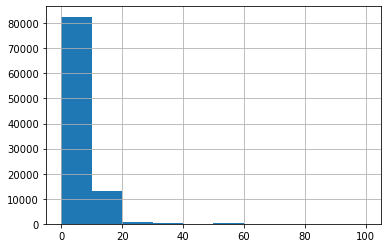

In [273]:
liwc['posemo'].hist()

In [274]:
liwc['negemo'].describe()

count    97160.000000
mean         2.476654
std          5.213873
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max        100.000000
Name: negemo, dtype: float64

In [275]:
liwc['power'].describe()

count    97160.000000
mean         4.803396
std          6.680074
min          0.000000
25%          0.000000
50%          0.000000
75%          7.410000
max        100.000000
Name: power, dtype: float64

In [276]:
liwc['anger'].describe()

count    97160.00000
mean         1.21631
std          3.94703
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max        100.00000
Name: anger, dtype: float64

# How do the tweets vary over time? 

In [277]:
# Make sure dates are in the right format (datetime objects instead of strings)
from dateutil.parser import parse

results = []
for i in liwc['date']:
    try:
        ni = parse(i)
        
    except Exception as e:
        print(e,i)
        ni = None
        
    results.append(ni)

liwc['parsed_date'] = results

# remove time zone info 
liwc['parsed_date'] = [i.replace(tzinfo=None) for i in liwc['parsed_date']]

day is out of range for month: 0 0


In [279]:
min(liwc['parsed_date'])

Timestamp('2022-06-01 00:02:12')

In [278]:
max(liwc['parsed_date'])

Timestamp('2022-06-30 23:59:32')

In [280]:
liwc['rt_count']=liwc['rt_count'].astype(float)

In [281]:
# Group scores by date, take the mean, then standardise!
gr = liwc[['posemo','negemo','rt_count','parsed_date']].groupby(pd.Grouper(key='parsed_date', freq='D', convention='start')).mean()
gr = (gr-gr.mean())/gr.std()


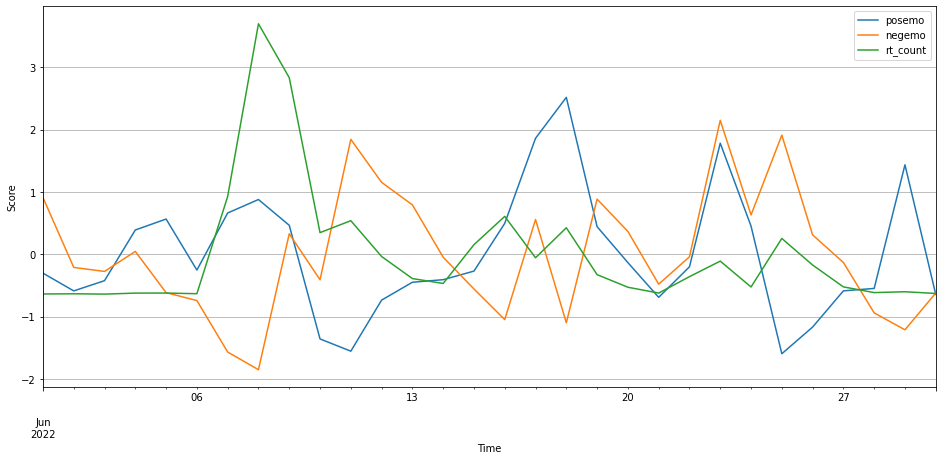

In [282]:
fig, ax = plt.subplots(figsize=(16, 7))
gr.plot(ax=ax)
#ax.ylabel('Normalised monthly tweet count')
#plt.xlabel('Date')
ax.set(xlabel='Time',ylabel='Score')
plt.grid(True)


In [283]:
import scipy
from scipy.signal import find_peaks
pos_peaks = scipy.signal.find_peaks(gr['posemo'])
neg_peaks = scipy.signal.find_peaks(gr['negemo'])

In [284]:
pos_peaks

(array([ 4,  7, 17, 22, 28]), {})

In [285]:
neg_peaks

(array([ 3,  8, 10, 16, 18, 22, 24]), {})

In [286]:
p_dates = []
for n,date in enumerate(gr.index):
    if n in list(pos_peaks[0]): 
        p_dates.append(date.strftime("%Y-%m-%d"))

n_dates = []
for n,date in enumerate(gr.index):
    if n in list(neg_peaks[0]): 
        n_dates.append(date.strftime("%Y-%m-%d"))


In [287]:
p_dates

['2022-06-05', '2022-06-08', '2022-06-18', '2022-06-23', '2022-06-29']

In [288]:
n_dates

['2022-06-04',
 '2022-06-09',
 '2022-06-11',
 '2022-06-17',
 '2022-06-19',
 '2022-06-23',
 '2022-06-25']

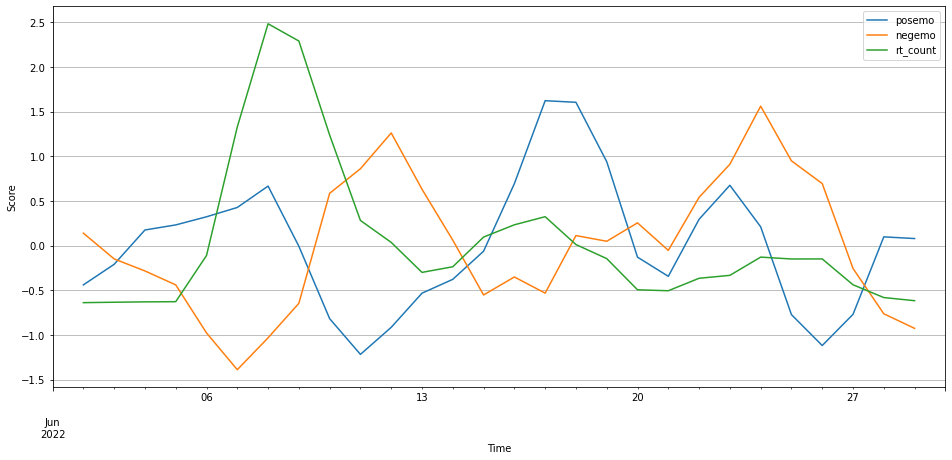

In [289]:
fig, ax = plt.subplots(figsize=(16, 7))

gr.rolling(window=3,center=True).mean().plot(ax=ax)
#gr.plot(ax=ax)
#ax.ylabel('Normalised monthly tweet count')
#plt.xlabel('Date')
ax.set(xlabel='Time',ylabel='Score')

plt.grid(True)

# Quick look at how the more positive tweets vary in terms of word frequecy relative to the more negative tweets

In [290]:
pos = liwc[liwc['posemo']>liwc['posemo'].mean()]
neg = liwc[liwc['negemo']>liwc['negemo'].mean()]

In [291]:
pos.shape

(49947, 104)

In [292]:
neg.shape

(25143, 104)

In [314]:
pos_freq = freq(pos,'cleaned')
print(sorted(pos_freq, key=pos_freq.get, reverse=True)[:30])

['q1', 'billion', 'profits', 'bp', '2021', 'gas', 'rbreich', '2022', 'increase', 'compared', '100', '5480000000', 'expensive', '6…', 'bravenewfilms', 'chevron', 'quarter', 'first', 'profit', '55', 'net', 'reported', 'shell', 'year', 'big', 'doubled', '88', '65', 'oils', '913']


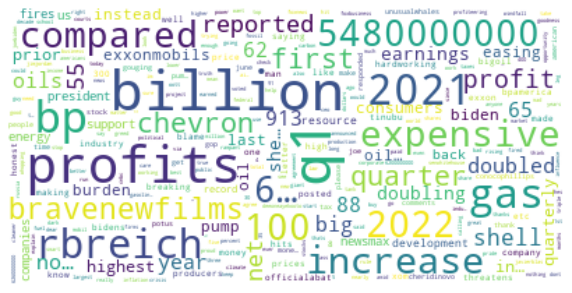

In [315]:
wordcloud = WordCloud(max_font_size=40, max_words=500, background_color="white").generate_from_frequencies(pos_freq)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
list(pos.sort_values('posemo',ascending=False)['text'])

In [316]:
neg_freq = freq(neg,'cleaned')
print(sorted(neg_freq, key=neg_freq.get, reverse=True)[:30])

['oil', 'biden', 'president', 'breaking', 'company', 'americans', 'planet', 'destroying', 'robbing', 'bashes', 'occupydemocrats', 'blind…', 'gas', 'got', 'tinubu', 'mobil', 'profits', 'bola', 'checks', 'resigned', 'ahmed', 'background', 'hint', 'afamdeluxo', 'm…', 'year', 'last', 'q1', 'pump', 'instead']


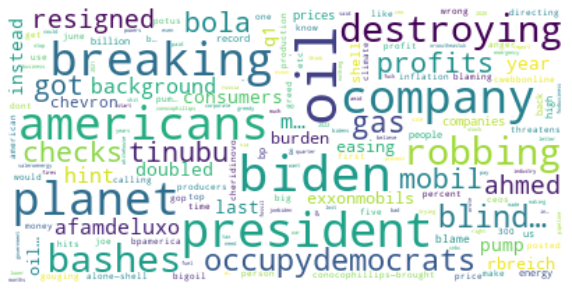

In [317]:
wordcloud = WordCloud(max_font_size=40, max_words=500, background_color="white").generate_from_frequencies(neg_freq)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
list(neg.sort_values('negemo',ascending=False)['text'])

## There are still a lot of ways we could improve the preprocessing of the tweets (i.e. there are still some unwanted characters and weird terms that we should investigate and likely remove), but the purpose of this examples is to show you the basics of how a data collection and processing pipeline works. The final fine-tuning of the pipeline is unique to each dataset and task you have.

## What if we don't want to see retweets?

In [318]:
rts = []
for i in liwc['text']:
    if i.startswith('RT'): rts.append(1)
    else: rts.append(0)

In [319]:
liwc['rt']=rts

# subset without retweets
rliwc = liwc[liwc['rt']==0]

# subset with only retweets
wrliwc = liwc[liwc['rt']==1]

In [320]:
rliwc.shape

(19088, 105)

In [321]:
wrliwc.shape

(78074, 105)

In [322]:
# full dataset mean for positive emotion
liwc['posemo'].mean()

4.890986620010401

In [323]:
# subset with no retweets mean for positive emotion
rliwc['posemo'].mean()

4.507387613957817

In [324]:
# subset with only retweets mean for positive emotion
wrliwc['posemo'].mean()

4.984761380231337

In [325]:
# full dataset mean for negative emotion
liwc['negemo'].mean()

2.4766538699045535

In [326]:
# subset with no retweets mean for negative emotion
rliwc['negemo'].mean()

3.4691601173634883

In [327]:
# subset with only retweets mean for negative emotion
wrliwc['negemo'].mean()

2.234025411788557

# What else can we do with this data?
- Topic modelling (usually requires you to aggregate over some time period because most topic modelling algorithms work best on longer texts)
- Regressions to determine the relationship between the use of particular features and the retweets a tweet recieves
- More sophisiticated classification of the specific narratives and frames used to discuss Exxon in the dataset 

# What are the issues with this data?
- Retweets 
- URLs and images 
- "Netspeak"
- Lack of context from LIWC